In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import warnings

import gseapy as gp
from gseapy.plot import barplot, dotplot
import gffpandas.gffpandas as gffpd

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

path_to_data='/Users/aleksandradenisova/Desktop/coursework/data/'

In [2]:
order = pd.read_csv(f'{path_to_data}stage4/sorted_inno_sp.csv')
order = order.rename(columns = {'VGL ID':'sp2'})
order.head()

,TotInno_resResEff2022,sp2
0,1.974601,bHirRus1
1,1.950304,bAquChr1
2,1.565219,bCorMon1
3,1.445271,bEriRub2
4,1.357739,bSteHir1


In [3]:
table_names = ['two_alleles.tsv', 'fixed_inno.tsv', 'fixed_noninno.tsv']
cons_in_table = ['cons','inno','non_inno']

all_dfs = []
for i in range(3):
    df = pd.read_csv(f'{path_to_data}final_data/{table_names[i]}', sep = '\t')
    df['start'] = df['start']+1 
    df['type'] = cons_in_table[i]
    
    print(f'number of positions:  {df.shape[0]}')
    
    df3 = df[(((df['n_inno']==4)&(df['n_noninno']==4)) |
              ((df['n_inno']==3)&(df['n_noninno']==4)) | #&((df['inno_N']==1)|(df['inno_-']==1)))|
              ((df['n_noninno']==3)&(df['n_inno']==4))) #((df['noninno_N']==1)|(df['noninno_-']==1))))
              &(df[cons_in_table[i]]==True)]

    print(f'number of positions:  {df3.shape[0]}')
    
    all_dfs.append(df3)
    
df = pd.concat(all_dfs)

number of positions:  12271
number of positions:  3262
number of positions:  13637
number of positions:  3809
number of positions:  10663
number of positions:  3040


In [4]:
df_chrom = pd.read_csv('~/Desktop/coursework/data/stage2/chroms_zebra.tsv', sep = '\t')[:-1]

df_chrom['Molecule name'] = df_chrom['Molecule name'].apply(lambda x: x.split()[1])
df1 = df_chrom[['RefSeq sequence', 'Molecule name']].rename(columns= {'RefSeq sequence':'chrom'})
df1.head()

,chrom,Molecule name
0,NC_044211.2,1
1,NC_044212.2,1A
2,NC_044213.2,2
3,NC_044214.2,3
4,NC_044215.2,4


In [5]:
df_p = df
    
df2 = pd.merge(df1,df_p, on='chrom').rename(columns = {
                                                    'chrom':'#CHROM', 'start':'POS', 
                                                    'Alt_noninno':'REF', 'Ref_inno':'ALT'})
df2['ID'] = '.'
df2['FILTER'] = '.'
df2['INFO'] = '.'
df2['POS'] = df2['POS']

df3 = df2[['#CHROM', 'POS','ID',  'REF','ALT', 'FILTER', 'INFO', 'type']]

df3.to_csv(f'{path_to_data}/final_data/positions_for_8.vcf', 
            index = False,
            sep = '\t')

### Launched from /Users/aleksandradenisova/Desktop/coursework/code/scripts/scripts


sh bash_snpEff.sh final_data positions_for_8.vcf 2> ~/Desktop/coursework/data/final_data/zibra.log

### Cобираем мутации из полученных файлов

In [7]:
df_ann = pd.read_csv(f'{path_to_data}/final_data/positions_for_8.vcf.ann', 
                     skiprows=6, 
                     sep = '\t', 
                     names = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'FILTER', 'smth','INFO'],
)
df_ann['type_of_pos'] = df_ann['INFO'].apply(lambda x: x.split(';')[0])
df_ann['INFO'] = df_ann['INFO'].apply(lambda x: x.split(';')[1])

In [8]:
ans = []
for idx in df_ann.index:
    new_info =  df_ann['INFO'].iloc[idx].split('|,')

    for inf in new_info:
        tt = df_ann.iloc[idx]
        tt['info'] = inf
        ans.append(tt)

df_new = pd.DataFrame(ans).drop(columns = 'INFO').reset_index(drop=True)
df_new['type'] = df_new['info'].apply(lambda x: x.split('|')[1])
df_new['gene_name'] = df_new['info'].apply(lambda x: x.split('|')[3])
df_new['effect'] = df_new['info'].apply(lambda x: x.split('|')[2])

In [10]:
df_new.head()

,#CHROM,POS,ID,REF,ALT,FILTER,smth,type_of_pos,info,type,gene_name,effect
0,NC_044211.2,407365,.,G,A,.,.,cons,ANN=A|intron_variant|MODIFIER|TMEM45A|TMEM45A|...,intron_variant,TMEM45A,MODIFIER
1,NC_044211.2,407365,.,G,A,.,.,cons,A|intron_variant|MODIFIER|TMEM45A|TMEM45A|tran...,intron_variant,TMEM45A,MODIFIER
2,NC_044211.2,1153711,.,T,C,.,.,cons,ANN=C|intergenic_region|MODIFIER|TRNAI-AAU-LOC...,intergenic_region,TRNAI-AAU-LOC121470433,MODIFIER
3,NC_044211.2,1305679,.,T,C,.,.,cons,ANN=C|intergenic_region|MODIFIER|LOC121470433-...,intergenic_region,LOC121470433-ALCAM,MODIFIER
4,NC_044211.2,1481305,.,T,C,.,.,cons,ANN=C|intergenic_region|MODIFIER|LOC121470433-...,intergenic_region,LOC121470433-ALCAM,MODIFIER


#### Итого отобрано генов:

In [13]:
df_genes = pd.read_csv(f'{path_to_data}/final_data/positions_for_8.vcf.txt', 
            sep = '\t', 
            skiprows=1, 
)
df_genes.head()

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,...,variants_effect_downstream_gene_variant,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_acceptor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
0,A2M,A2M,XM_030268194.3,protein_coding,0,0,0,2,0,0,...,2,0,0,0,0,0,0,0,0,0
1,AADAC,AADAC,XM_030280502.3,protein_coding,0,0,0,2,0,0,...,0,0,2,0,0,0,0,0,0,0
2,AADAT,AADAT,XM_041715834.1,protein_coding,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,AAR2,AAR2,XM_030288651.3,protein_coding,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,AARS1,AARS1,XM_030282133.3,protein_coding,0,0,0,2,0,0,...,1,0,1,0,0,0,0,0,0,0


In [47]:
type_mut = ['cons', 'inno', 'non_inno']
num = 0

list_of_missence = list(df_genes[df_genes['variants_effect_missense_variant']>0]['GeneId'].unique())
for num in range(3):
    list_genes_type = df_new[(df_new['type_of_pos'] == type_mut[num])&
                            (df_new['type'].apply(lambda x: 'missense' in x))]['gene_name'].unique()
    to_print = [i for i in list_of_missence if i in list_genes_type]
    print(f'\n{type_mut[num]}\n')
    print('\n'.join(to_print))


cons

CLEC14A
COL7A1
EPG5
HRH1
KMT2D
LOC100218872
LOC100225136
LOC100231134
LOC115492593
MKI67
NICN1
PCSK4
PPARGC1B
RAG2
RSRC2
SH3D19
SRPK1
TNC
VWA5B1
WDR6
ZNF710

inno

CACNA1E
CHRNG
EPPK1
GPR37L1
IFNAR1
JAML
KIAA1328
LOC100232561
LOC101234167
LOC105758679
LOC105760670
LOC116808853
LOC121469171
LOC121469259
LOC121469885
LPXN
MAP1A
NEU4
NUP98
RCCD1
RELT
RIF1
RNF213
SLC51A
SMC2
TANGO6
UNC13C
XPNPEP3

non_inno

C22H2orf42
CCDC88C
ERICH3
FAM161A
GPR179
IGFN1
INKA2
KRTCAP3
LOC100223936
LOC100227365
LOC115490891
LOC121470139
LOC121470173
OIT3
PLCXD1
SI
SPAG5
TARS1
TBC1D4


In [48]:
unique_genes_big = df_genes['GeneId'].unique()
df_new = df_new[df_new['gene_name'].apply(lambda x: x in unique_genes_big)]
df_new[['type_of_pos', 'gene_name']].drop_duplicates()['type_of_pos'].value_counts()

inno        2470
cons        2324
non_inno    2070
Name: type_of_pos, dtype: int64

In [17]:
len(unique_genes_big)

5406

In [49]:
go_BP = gp.get_library(name='GO_Biological_Process_2021', organism='Human')
go_MF = gp.get_library(name='GO_Molecular_Function_2021', organism='Human')
go_CC = gp.get_library(name='GO_Cellular_Component_2021', organism='Human')
go_reactome = gp.get_library(name='Reactome_2016', organism='Human')

def get_df(database, genelist, background):
    enr = gp.enrichr(gene_list=genelist ,
        gene_sets=database,
        background = background,  
        outdir=None,
        cutoff=0.5,                          
     )
    return enr

def plot(df, bg, name):
    name = ' '.join(name.split('_'))
    barplot(df.res2d,title= name+bg, top_term=15, cutoff=0.05,color = 'r')
    plt.plot([l,l],[-1, 15], linestyle = '--',color='k', label = '- log10(0.05)')

In [50]:
annotation = gffpd.read_gff3('{}stage2/{}'.format(path_to_data, 'GCF_003957565.2_bTaeGut1.4.pri_genomic.gff'))

df_ori = annotation.df
df_ori['chrom']=df_ori['seq_id']
df = df_ori[df_ori['type']=='gene']

df['element_ID'] = df['attributes'].apply(lambda x: x.split(';')[0].split('=')[1].split('-')[1])
background = df['element_ID'].tolist()

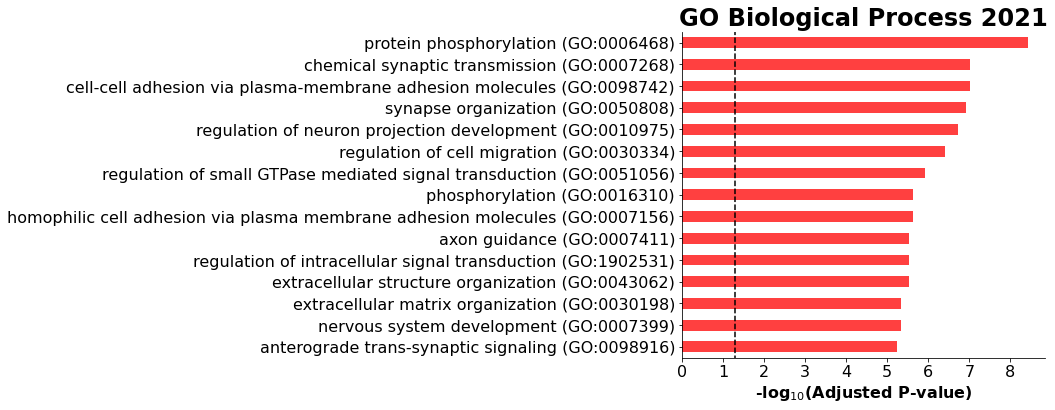

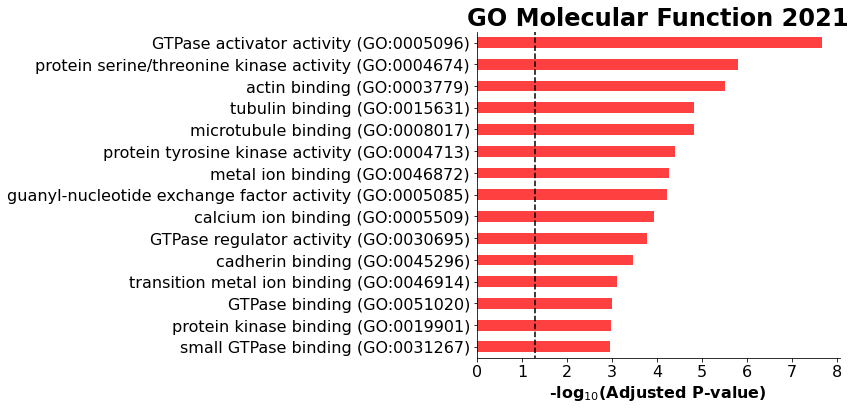

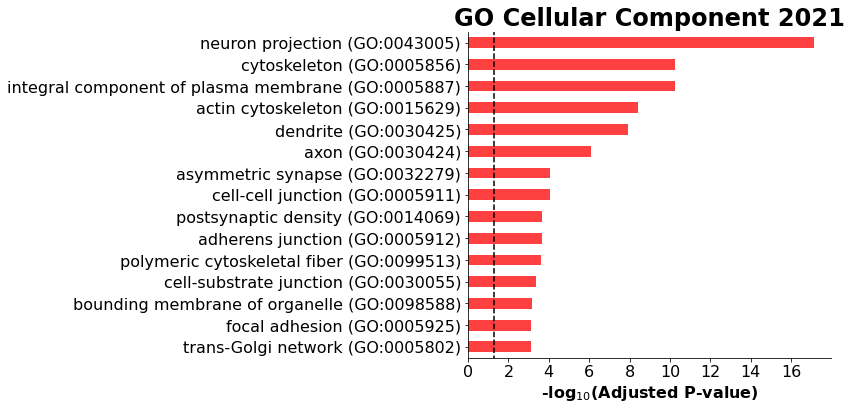

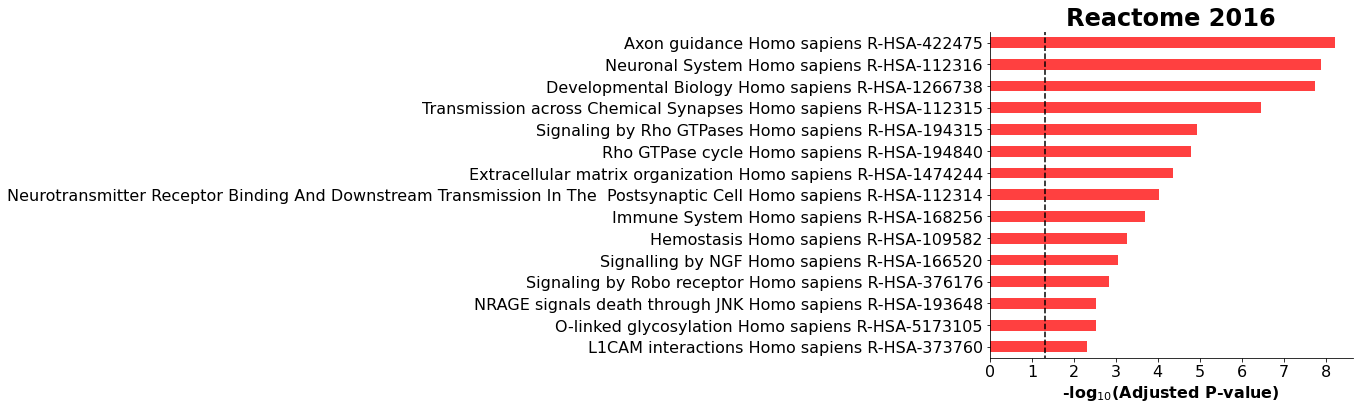

In [51]:
l = -np.log10(0.05)
plot(get_df(go_BP, list(unique_genes_big), background), '', 'GO_Biological_Process_2021')
plot(get_df(go_MF, list(unique_genes_big), background), '', 'GO_Molecular_Function_2021')
plot(get_df(go_CC, list(unique_genes_big), background), '', 'GO_Cellular_Component_2021')
plot(get_df(go_reactome, list(unique_genes_big), background), '', 'Reactome_2016')

In [52]:
df_genes.head()

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,...,variants_effect_downstream_gene_variant,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_acceptor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
0,A2M,A2M,XM_030268194.3,protein_coding,0,0,0,2,0,0,...,2,0,0,0,0,0,0,0,0,0
1,AADAC,AADAC,XM_030280502.3,protein_coding,0,0,0,2,0,0,...,0,0,2,0,0,0,0,0,0,0
2,AADAT,AADAT,XM_041715834.1,protein_coding,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,AAR2,AAR2,XM_030288651.3,protein_coding,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,AARS1,AARS1,XM_030282133.3,protein_coding,0,0,0,2,0,0,...,1,0,1,0,0,0,0,0,0,0


Распределение по транскриптам:


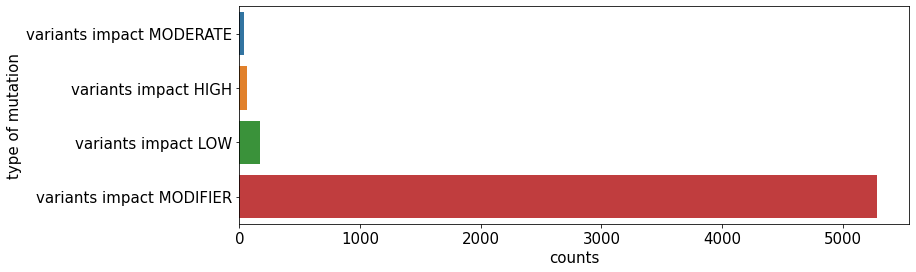

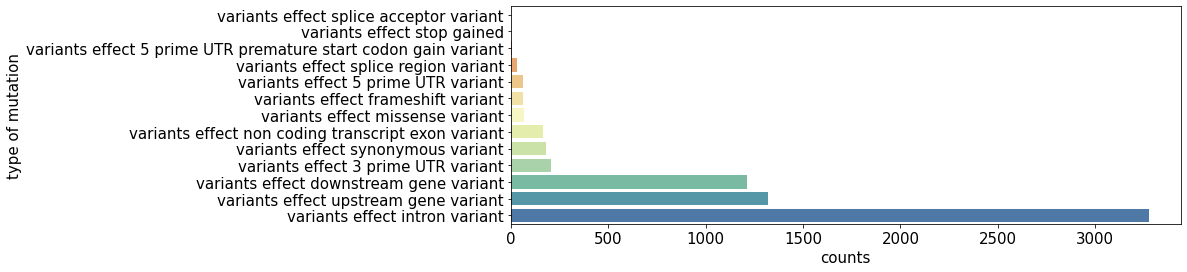

variants_impact_HIGH                                                65
variants_impact_LOW                                                175
variants_impact_MODERATE                                            40
variants_impact_MODIFIER                                          5284
variants_effect_3_prime_UTR_variant                                208
variants_effect_5_prime_UTR_premature_start_codon_gain_variant       7
variants_effect_5_prime_UTR_variant                                 62
variants_effect_downstream_gene_variant                           1211
variants_effect_frameshift_variant                                  63
variants_effect_intron_variant                                    3275
variants_effect_missense_variant                                    68
variants_effect_non_coding_transcript_exon_variant                 163
variants_effect_splice_acceptor_variant                              1
variants_effect_splice_region_variant                               32
varian

In [53]:
print('Распределение по транскриптам:')

df_counts_types = pd.DataFrame((df_genes.groupby("GeneId").sum()!=0).sum(), columns = ['counts'])
df_counts_types['type_mut'] = df_counts_types.index
df_counts_types['type_mut'] = df_counts_types['type_mut'].apply(lambda x: ' '.join(x.split('_')))

plt.figure(figsize = (12,4))
sns.barplot(data = df_counts_types[:4].sort_values(by = 'counts', ascending = True), x = 'counts', y = 'type_mut')
plt.ylabel('type of mutation')
plt.savefig(f'{path_to_data}final_data/pics/snpEff_effect_force.png',  bbox_inches='tight', dpi = 400)
plt.show()

a = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True)
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (12,4))

df_counts_sort = df_counts_types[4:].sort_values(by = 'counts', ascending = True) 
df_counts_sort['counts2'] = df_counts_sort['counts'].apply(lambda x: np.log(x))
sns.barplot(data = df_counts_sort, 
            x = 'counts', 
            y = 'type_mut',
           palette = 'Spectral')
plt.ylabel('type of mutation')
plt.savefig(f'{path_to_data}final_data/pics/snpEff_effect_pos.png',  bbox_inches='tight', dpi = 400)
plt.show()
df_counts_types['counts']

In [54]:
df_genes[(df_genes['variants_impact_HIGH']>=1)
        &(df_genes['variants_effect_stop_gained']>=1)]['#GeneName'].unique()

array(['TARS1'], dtype=object)

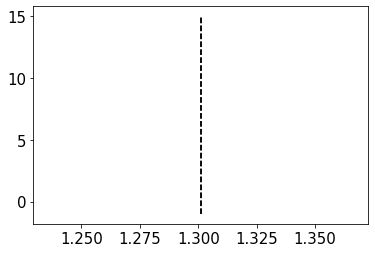

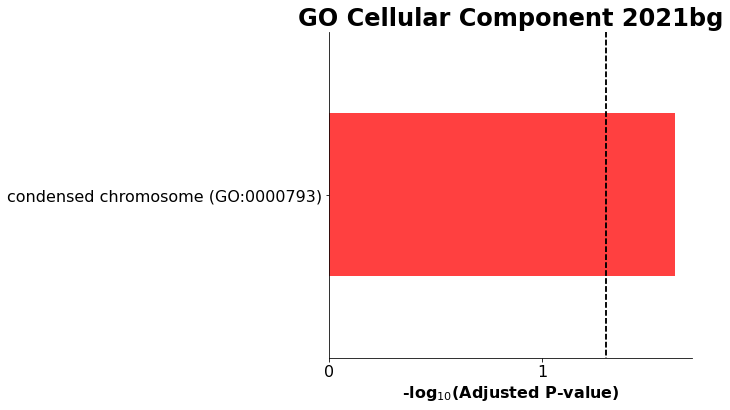

In [55]:
plot(get_df(go_BP, unique_genes, background), 'bg', 'GO_Molecular_Function_2021')
plot(get_df(go_MF, unique_genes, background), 'bg', 'GO_Biological_Process_2021')
plot(get_df(go_CC, unique_genes, background), 'bg', 'GO_Cellular_Component_2021')
plot(get_df(go_reactome, unique_genes, background), 'bg', 'Reactome_2016')

In [39]:
df_genes_miss = df_genes[df_genes['variants_effect_missense_variant']>=1]
unique_genes_miss = list(df_genes_miss['GeneId'].unique())
file = open(f'{path_to_data}stage5/genes_miss.txt', 'w')
file.write('\n'.join(unique_genes_miss))
file.close()

In [42]:
df_new[df_new['gene_name'].apply(lambda x: x in unique_genes)]

,#CHROM,POS,ID,REF,ALT,FILTER,smth,type_of_pos,info,type,gene_name,effect
472,NC_044211.2,46387564,.,A,G,.,.,cons,ANN=G|intron_variant|MODIFIER|TBC1D4|TBC1D4|tr...,intron_variant,TBC1D4,MODIFIER
473,NC_044211.2,46387564,.,A,G,.,.,cons,G|intron_variant|MODIFIER|TBC1D4|TBC1D4|transc...,intron_variant,TBC1D4,MODIFIER
474,NC_044211.2,46387564,.,A,G,.,.,cons,G|intron_variant|MODIFIER|TBC1D4|TBC1D4|transc...,intron_variant,TBC1D4,MODIFIER
475,NC_044211.2,46387564,.,A,G,.,.,cons,G|intron_variant|MODIFIER|TBC1D4|TBC1D4|transc...,intron_variant,TBC1D4,MODIFIER
476,NC_044211.2,46387564,.,A,G,.,.,cons,G|intron_variant|MODIFIER|TBC1D4|TBC1D4|transc...,intron_variant,TBC1D4,MODIFIER
...,...,...,...,...,...,...,...,...,...,...,...,...
46210,NC_044241.2,43428303,.,G,"A,T,C",.,.,non_inno,C|missense_variant|MODERATE|TARS1|TARS1|transc...,missense_variant,TARS1,MODERATE
46211,NC_044241.2,43428303,.,G,"A,T,C",.,.,non_inno,T|missense_variant|MODERATE|TARS1|TARS1|transc...,missense_variant,TARS1,MODERATE
46887,NC_044242.2,1210973,.,T,C,.,.,cons,ANN=C|missense_variant|MODERATE|KMT2D|KMT2D|tr...,missense_variant,KMT2D,MODERATE
46888,NC_044242.2,1218005,.,G,A,.,.,cons,ANN=A|intron_variant|MODIFIER|KMT2D|KMT2D|tran...,intron_variant,KMT2D,MODIFIER


In [41]:
df_new_miss = df_new[df_new['gene_name'].apply(lambda x: x in unique_genes)]
df_new_miss[['type_of_pos', 'gene_name']].drop_duplicates()['type_of_pos'].value_counts()

cons        35
inno        35
non_inno    33
Name: type_of_pos, dtype: int64

In [193]:
print('\n'.join(unique_genes))

ACTL10
ADCY9
AGBL1
AOC2
ARHGEF33
ASTN1
BAZ2B
BCO2
BOD1L1
BSN
CACNA1E
CADPS
CASKIN2
CCDC88C
CDK9
CEP104
CKAP5
CLEC14A
CLPB
CR2
CREB5
DDB1
DNAH17
DNAJB13
EPG5
EYS
F8
FAM161A
FANCM
FASTKD3
FAT4
FTSJ3
GAPVD1
GARRE1
GGT1
GLI2
GPR179
GRB10
GRM1
GSE1
HTR5A
IFT140
INKA2
INTS8
IQSEC3
ISM2
JAML
KIAA1328
KIAA1549
KIAA2013
KRTCAP3
LINGO1
LNX2
LOC100217969
LOC100218025
LOC100219145
LOC100219675
LOC100223706
LOC100224389
LOC100225136
LOC100225878
LOC100226503
LOC100231134
LOC100232370
LOC101234190
LOC105759186
LOC115497385
LOC121468130
LOC121469259
LRIG2
MAMDC4
MICU3
NCF1
NICN1
NMRAL1
OBSL1
OIT3
OTOG
P2RY4
PDE4D
PFKL
PLA2G12B
PLBD2
PLCXD1
PRAG1
PROB1
RASGEF1C
RELT
RET
RNF213
RSRC2
SALL4
SCARF2
SHMT1
SLC4A4
SLC51A
SMARCA5
SMG8
SPEG
SPG11
SPTB
SVOPL
TARS1
TBC1D4
THOC1
TMEM131
TMEM198
TNRC18
TRIM36
TYR
UBE2K
USH1C
USH2A
WASL
WDR12
WDR6
WNK1
XPNPEP3
ZCCHC17
ZNF507


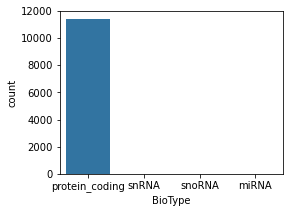

Counts:


protein_coding    11449
miRNA                19
snoRNA               11
snRNA                 4
Name: BioType, dtype: int64

In [45]:
plt.figure(figsize = (4,3))
sns.countplot(data=df_genes, x="BioType")
plt.show()

print("Counts:")
df_genes['BioType'].value_counts()

In [46]:
df_genes[df_genes['BioType']=='snoRNA']

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,...,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_acceptor_variant,variants_effect_splice_donor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
6356,LOC115495693,LOC115495693,XR_003960995.1,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6361,LOC115495888,LOC115495888,XR_003961213.3,snoRNA,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
6441,LOC115496473,LOC115496473,XR_003961976.1,snoRNA,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,2
6442,LOC115496475,LOC115496475,XR_003961978.1,snoRNA,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,2
6443,LOC115496477,LOC115496477,XR_003961980.1,snoRNA,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,2
6579,LOC115497774,LOC115497774,XR_003963361.3,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6580,LOC115497777,LOC115497777,XR_003963364.3,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6584,LOC115497831,LOC115497831,XR_003963408.3,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6585,LOC115497843,LOC115497843,XR_003963420.3,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6586,LOC115497844,LOC115497844,XR_003963421.3,snoRNA,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
df_genes[df_genes['variants_effect_missense_variant']>0]

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,...,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_acceptor_variant,variants_effect_splice_donor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
145,ACTL10,ACTL10,XM_030288865.3,protein_coding,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
191,ADCY9,ADCY9,XM_002194859.6,protein_coding,1,0,0,2,0,0,...,1,2,1,0,0,0,0,0,0,0
192,ADCY9,ADCY9,XM_030285269.3,protein_coding,1,0,0,2,0,0,...,1,2,1,0,0,0,0,0,0,0
333,AGBL1,AGBL1,XM_030281428.3,protein_coding,0,1,1,1,0,0,...,0,1,1,0,0,0,0,0,1,0
334,AGBL1,AGBL1,XM_030281429.3,protein_coding,0,1,1,1,0,0,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12625,ZNF507,ZNF507,XM_030282173.3,protein_coding,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
12626,ZNF507,ZNF507,XM_030282174.3,protein_coding,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
12627,ZNF507,ZNF507,XM_030282176.3,protein_coding,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
12628,ZNF507,ZNF507,XM_030282177.3,protein_coding,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [49]:
[i for i in df_genes['GeneId'].unique() if i.startswith('TRNAP')]

['TRNAP-AGG_1', 'TRNAP-CGG']

In [50]:
df_genes[df_genes['GeneId']=='TRNAP-CGG']

,#GeneName,GeneId,TranscriptId,BioType,variants_impact_HIGH,variants_impact_LOW,variants_impact_MODERATE,variants_impact_MODIFIER,variants_effect_3_prime_UTR_variant,variants_effect_5_prime_UTR_premature_start_codon_gain_variant,...,variants_effect_frameshift_variant,variants_effect_intron_variant,variants_effect_missense_variant,variants_effect_non_coding_transcript_exon_variant,variants_effect_splice_acceptor_variant,variants_effect_splice_donor_variant,variants_effect_splice_region_variant,variants_effect_stop_gained,variants_effect_synonymous_variant,variants_effect_upstream_gene_variant
11900,TRNAP-CGG,TRNAP-CGG,unassigned_transcript_14,protein_coding,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
